In [1]:

import importlib
import data_prep as dp
import pandas as pd
importlib.reload(dp)
print(dir(dp))  # Check if functions appear now

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [2]:
import matplotlib.pyplot as plt

In [ ]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

In [183]:
df = pd.read_csv('./../data/Sentiment Macro 7Y News 2.5K Cap.csv')

In [184]:
df.index = pd.to_datetime(df['date'])

In [185]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

df['mean_sentiment_decay'] = df['overall_mean'].shift(1)  # Decay from yesterday
df['shock_pos'] = df['overall_max'] #best new
df['shock_neg'] = df['overall_min'] #worst new 
df['sentiment_dominance'] = df['summary_pos_count'] - df['summary_neg_count'] # which type of new is more prevalent (p/n)?
df['dominance_trigger'] = (df['sentiment_dominance'] < -5).astype(int) #if one type of news is more prevalent than the other, it will trigger a shock



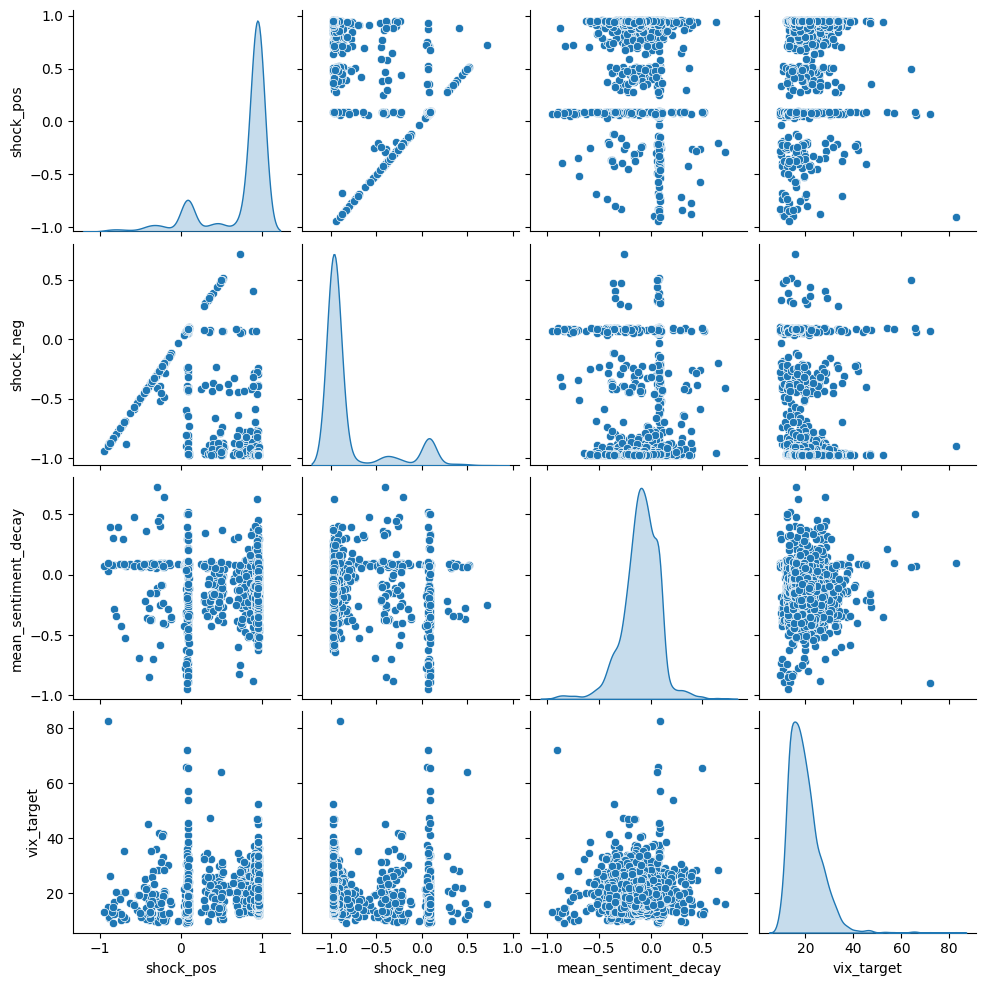

In [186]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target'], diag_kind='kde')


In [187]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]


In [188]:

train_size = 0.8  # 80% for training
split_idx = int(len(df) * train_size)

train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

df_model = train_df.dropna(subset=feature_sets[0] + ['vix_target']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_target']

model = MarkovRegression(y, exog=X, k_regimes=2, switching_variance=False)
results = model.fit(disp=False)
print(f"Features: {feature_sets[0]}")
print(f"AIC: {results.aic:.3f}, LogL: {results.llf:.3f}")
print(results.summary().tables[0])
print("-" * 80)


Train set: 1564 rows
Test set: 391 rows


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Features: ['shock_neg', 'dominance_trigger']
AIC: 9104.385, LogL: -4543.192
                        Markov Switching Model Results                        
Dep. Variable:             vix_target   No. Observations:                 1564
Model:               MarkovRegression   Log Likelihood               -4543.192
Date:                Sat, 12 Apr 2025   AIC                           9104.385
Time:                        15:27:46   BIC                           9152.580
Sample:                             0   HQIC                          9122.302
                               - 1564                                         
Covariance Type:               approx                                         
--------------------------------------------------------------------------------


In [189]:
# Get the most likely regime at each time step
df_model['regime_t'] = results.smoothed_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.5 else 0)
selected_features = feature_sets[0]


In [190]:
df_model['vix_target_t+1'] = df_model['vix_target'].shift(-1) #lag for predicting the vix level, not the regime prediction

regime_col = df_model['regime_t'].copy() #so that it doesnt erase

df_model = df_model.dropna(subset=selected_features + ['vix_target_t+1']).copy()

df_model['regime_t'] = regime_col.loc[df_model.index]


X = df_model[selected_features]
y = df_model['vix_target_t+1']

model = MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=2,
    switching_variance=False
)
results = model.fit() #model for predicting the vix level t+1


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [191]:
print(results.summary())



                        Markov Switching Model Results                        
Dep. Variable:         vix_target_t+1   No. Observations:                 1563
Model:               MarkovRegression   Log Likelihood               -4542.150
Date:                Sat, 12 Apr 2025   AIC                           9102.300
Time:                        15:27:47   BIC                           9150.489
Sample:                             0   HQIC                          9120.215
                               - 1563                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.0360      0.268     56.049      0.000      14.510      15.562
x1            -2.3310      0.366     -6.369      0.0

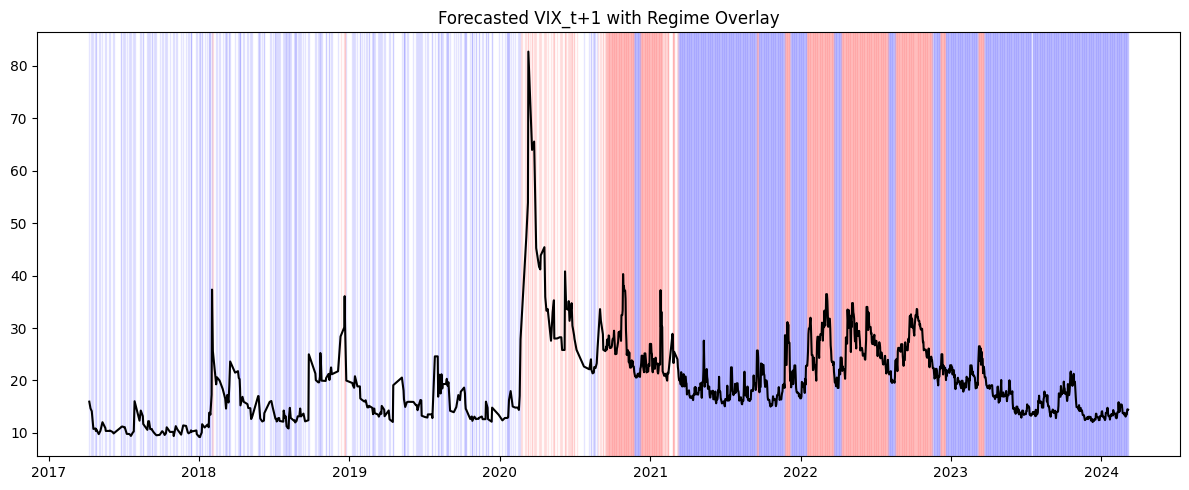

In [192]:
import matplotlib.pyplot as plt #graph vix t+1 with regime overlay

df_model['regime_t+1'] = df_model['regime_t'].shift(-1) #regime dataset for t+1

plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model['vix_target_t+1'], label='VIX_t+1', color='black')

for i in range(len(df_model)):
    color = 'red' if df_model['regime_t+1'].iloc[i] == 1 else 'blue'
    plt.axvspan(df_model.index[i], df_model.index[i], color=color, alpha=0.1)

plt.title('Forecasted VIX_t+1 with Regime Overlay')
plt.tight_layout()
plt.show()


In [232]:
df_model['regime_t'] = results.filtered_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.1 else 0) #regime dataset for t


In [233]:
df_model['regime_t+1'] = df_model['regime_t'].shift(-1) #regime dataset for t+1


In [234]:
classification_df = df_model.dropna(subset=selected_features + ['regime_t+1']).copy() #classification dataset for t+1, for telling if regime is panic or not
X_cls = classification_df[selected_features]
y_cls = classification_df['regime_t+1']


In [235]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=400, max_depth=7, random_state=42)
clf.fit(X_cls, y_cls)

# Evaluate
y_pred = clf.predict(X_cls)
print(classification_report(y_cls, y_pred))


              precision    recall  f1-score   support

         0.0       0.69      0.98      0.81       995
         1.0       0.86      0.22      0.35       567

    accuracy                           0.70      1562
   macro avg       0.77      0.60      0.58      1562
weighted avg       0.75      0.70      0.64      1562



In [236]:
probs = clf.predict_proba(X_cls)[:, 1]
classification_df['panic_prob'] = probs


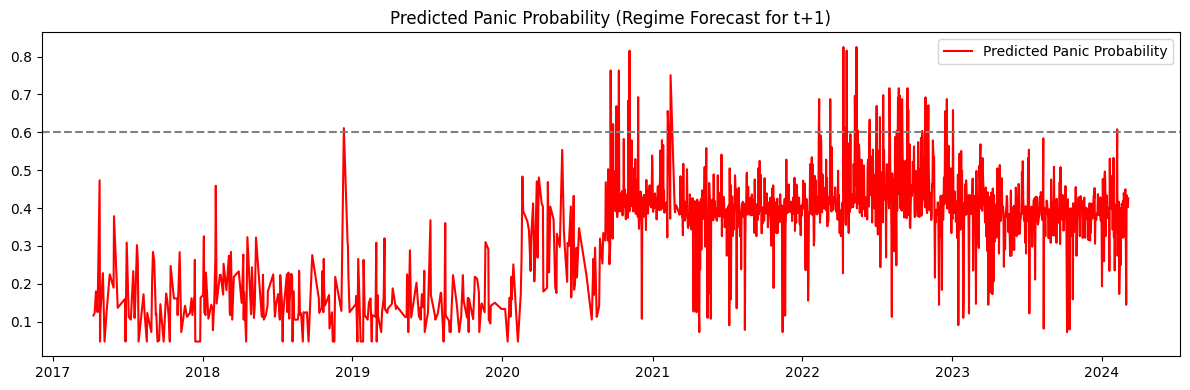

In [237]:
plt.figure(figsize=(12, 4))
plt.plot(classification_df.index, classification_df['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.6, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


In [238]:


classification_df.index = pd.to_datetime(classification_df.index)


,Unnamed: 0,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,...,vix_target,mean_sentiment_decay,shock_pos,shock_neg,sentiment_dominance,dominance_trigger,regime_t,vix_target_t+1,regime_t+1,panic_prob
date,,,,,,,,,,,,,,,,,,,,,
2024-03-01,1557,-0.134237,-0.974657,0.957517,83,74,-0.011035,-0.973516,0.956001,98,...,13.11,-0.038520,0.956759,-0.974086,9,0,0,13.49,0.0,0.434054
2024-03-02,1558,-0.064787,-0.974281,0.957517,14,6,0.108783,-0.952077,0.937433,18,...,13.49,-0.072636,0.947475,-0.963179,8,0,0,13.49,0.0,0.427577
2024-03-03,1559,0.080642,-0.973010,0.925472,22,4,-0.203441,-0.954654,0.951347,11,...,13.49,0.021998,0.938410,-0.963832,18,0,0,13.49,0.0,0.420507
2024-03-04,1560,-0.166234,-0.971696,0.948329,75,73,0.006171,-0.971192,0.951272,99,...,13.49,-0.061399,0.949800,-0.971444,2,0,0,14.46,0.0,0.402288
2024-03-05,1561,-0.202954,-0.974537,0.950236,60,62,-0.051251,-0.973615,0.947792,75,...,14.46,-0.080032,0.949014,-0.974076,-2,0,0,14.50,0.0,0.425958


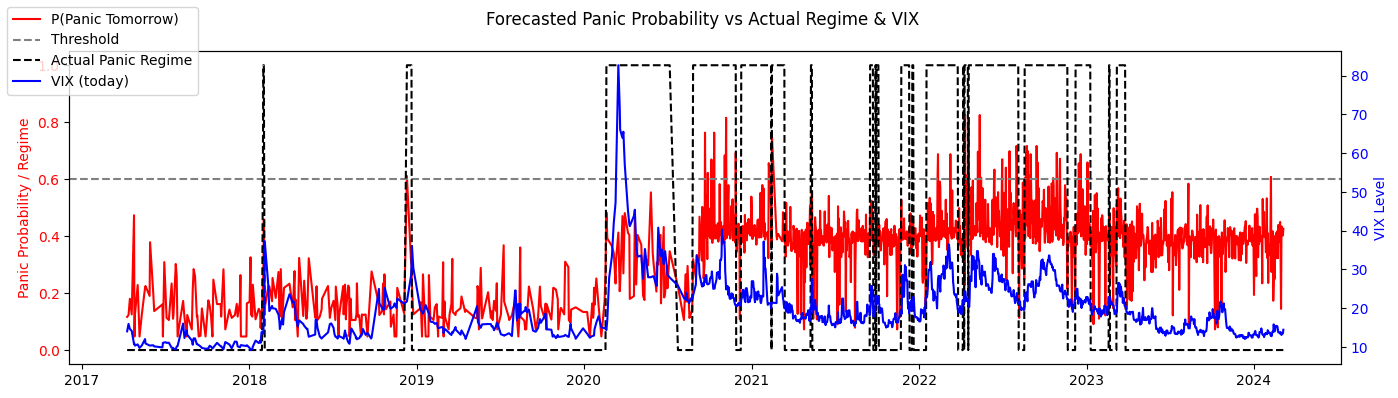

In [240]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.6, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


# Test


In [289]:
# 1. After fitting on training set
train_params = results.params

# 2. Prepare your test data
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)
test_df = test_df.dropna(subset=selected_features + ['vix_target_t+1']).copy()

X_test = test_df[selected_features]
y_test = test_df['vix_target_t+1']

# 3. Define same model on test data
model_test = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=2,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_test.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
test_df['regime_t'] = results_test.filtered_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.0015 else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
test_df['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

# 7. (Optional) Align as prediction for tomorrow
test_df['panic_prob_t+1'] = test_df['panic_prob_t+1'].shift(1)




/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


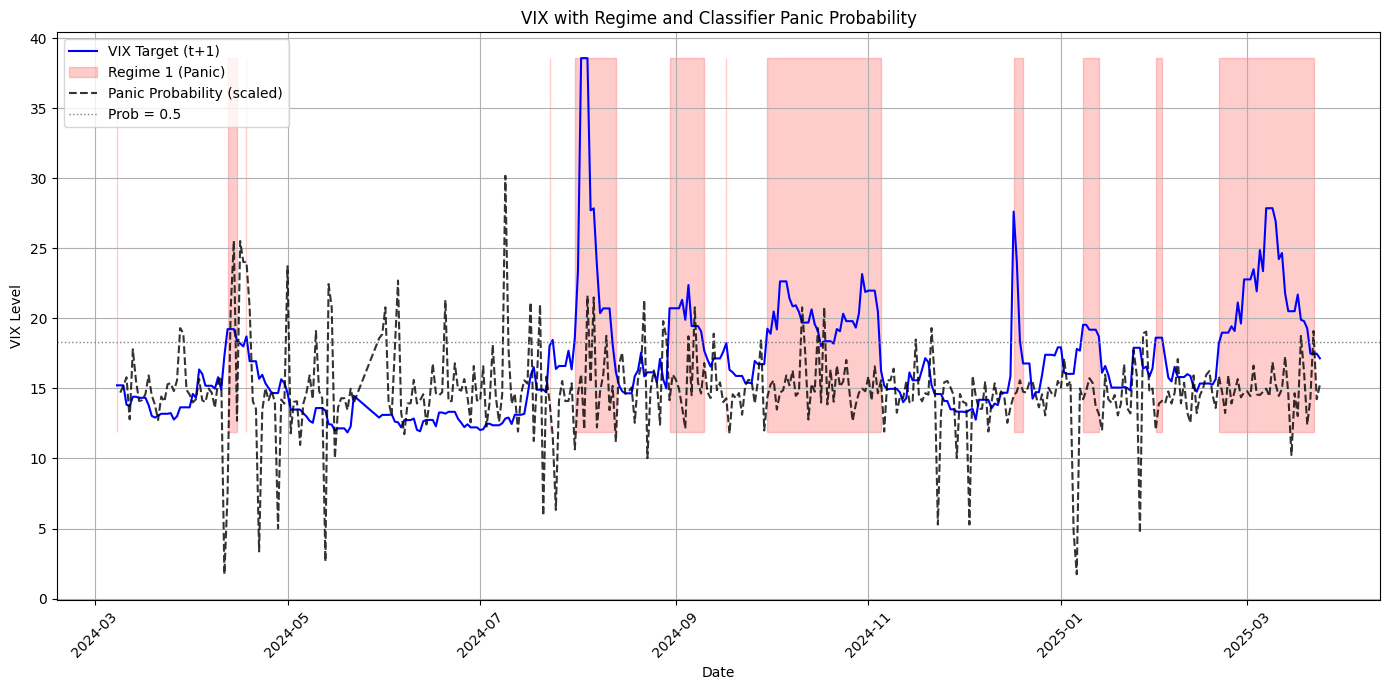

In [290]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_target_t+1"], label="VIX Target (t+1)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_target_t+1"].min(),
    test_df["vix_target_t+1"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target_t+1"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_target_t+1"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# New Part, forecast

In [269]:
calm_df = df_model[df_model['regime_t'] == 0]['shock_neg']
panic_df = df_model[df_model['regime_t'] == 1]['shock_neg']

In [270]:
df_model.head()

,Unnamed: 0,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,...,overall_neg_count,vix_target,mean_sentiment_decay,shock_pos,shock_neg,sentiment_dominance,dominance_trigger,regime_t,vix_target_t+1,regime_t+1
date,,,,,,,,,,,,,,,,,,,,,
2017-04-10,0,0.086258,0.086258,0.086258,1,0,0.089796,0.089796,0.089796,1,...,0,14.05,NaN,0.088027,0.088027,1,0,0,15.96,0.0
2017-04-13,1,0.070224,0.070224,0.070224,1,0,0.092980,0.092980,0.092980,1,...,0,15.96,0.088027,0.081602,0.081602,1,0,0,14.66,0.0
2017-04-16,2,0.059322,0.059322,0.059322,1,0,0.092611,0.092611,0.092611,1,...,0,14.66,0.081602,0.075966,0.075966,1,0,0,14.15,0.0
2017-04-20,3,0.070215,0.070215,0.070215,1,0,0.063073,0.063073,0.063073,1,...,0,14.15,0.075966,0.066644,0.066644,1,0,0,10.76,0.0
2017-04-25,4,-0.963146,-0.963146,-0.963146,0,1,-0.793722,-0.793722,-0.793722,0,...,2,10.76,0.066644,-0.878434,-0.878434,-1,0,0,10.85,0.0


In [271]:
from statsmodels.tsa.ar_model import AutoReg #change lags when more data is available

model_calm = AutoReg(calm_df, lags=10).fit()
model_panic = AutoReg(panic_df, lags=10).fit()

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [272]:
regime_today = df_model['regime_t'].iloc[-1]
model = model_panic if regime_today == 1 else model_calm

In [273]:
shock_forecast = []
history = [df_model['shock_neg'].dropna().iloc[-1]]  # Corrected here

for _ in range(10):
    next_val = model.predict(start=len(history), end=len(history)).iloc[0]

    shock_forecast.append(next_val)
    history.append(next_val)


In [274]:
# Given model_calm and model_panic already trained for this feature
history = [df_model['dominance_trigger'].dropna().iloc[-1]]
dom_forecast = []

for _ in range(10):
    next_val = model.predict(start=len(history), end=len(history)).iloc[0]
    dom_forecast.append(next_val)
    history.append(next_val)


In [275]:
decay_forecast = []
decay_hist = [df_model['mean_sentiment_decay'].dropna().iloc[-1]]

for _ in range(10):
    next_val = model.predict(start=len(decay_hist), end=len(decay_hist)).iloc[0]
    decay_forecast.append(next_val)
    decay_hist.append(next_val)


In [276]:
min_forecast = []
min_hist = [df_model['overall_min'].dropna().iloc[-1]]

for _ in range(10):
    next_val = model.predict(start=len(min_hist), end=len(min_hist)).iloc[0]
    min_forecast.append(next_val)
    min_hist.append(next_val)


In [277]:
domi_forecast = []
domi_hist = [df_model['sentiment_dominance'].dropna().iloc[-1]]

for _ in range(10):
    next_val = model.predict(start=len(domi_hist), end=len(domi_hist)).iloc[0]
    domi_forecast.append(next_val)
    domi_hist.append(next_val)


In [278]:
df_model['date'] = pd.to_datetime(df_model['date'])
df_model = df_model.set_index('date')


KeyError: 'date'

In [279]:
df_forecast = pd.DataFrame({
    'shock_neg': shock_forecast,
    'dominance_trigger': dom_forecast,
    'mean_sentiment_decay': decay_forecast,
    'overall_min': min_forecast,
    'sentiment_dominance': domi_forecast
}, index=pd.date_range(start=df_model.index[-1] + pd.Timedelta(days=1), periods=10))


In [281]:
X = df_model[selected_features]
X = sm.add_constant(X)  # this adds the intercept column


In [282]:

n_features = len(selected_features) + 1  # const + features

# Grab regime-specific coefficients
regime_0_params = results.params[:n_features]
regime_1_params = results.params[n_features:2*n_features]

X_future = df_forecast[selected_features]
X_future_const = sm.add_constant(X_future, has_constant='add')  # makes sure you don’t double-add
print(X_future_const.shape)  # should be (5, n_features + 1)

# Select which regime to simulate under (e.g., current regime)
regime_params = regime_0_params if regime_today == 0 else regime_1_params
#df_forecast['vix_pred'] = X_future_const @ regime_params
print("X_future_const shape:", X_future_const.shape)
print("Regime param shape:", results.params[:X_future_const.shape[1]].shape)


#results.predict(X_future)
n_features = X_future_const.shape[1]

regime_0_params = results.params[:n_features]
regime_1_params = results.params[n_features:2*n_features]
regime_params = regime_0_params if regime_today == 0 else regime_1_params

df_forecast['vix_pred'] = X_future_const.values @ regime_params.values


(10, 3)
X_future_const shape: (10, 3)
Regime param shape: (3,)


In [283]:
df_forecast['panic_prob'] = clf.predict_proba(df_forecast[selected_features])[:, 1]
df_forecast['regime_pred'] = clf.predict(df_forecast[selected_features])



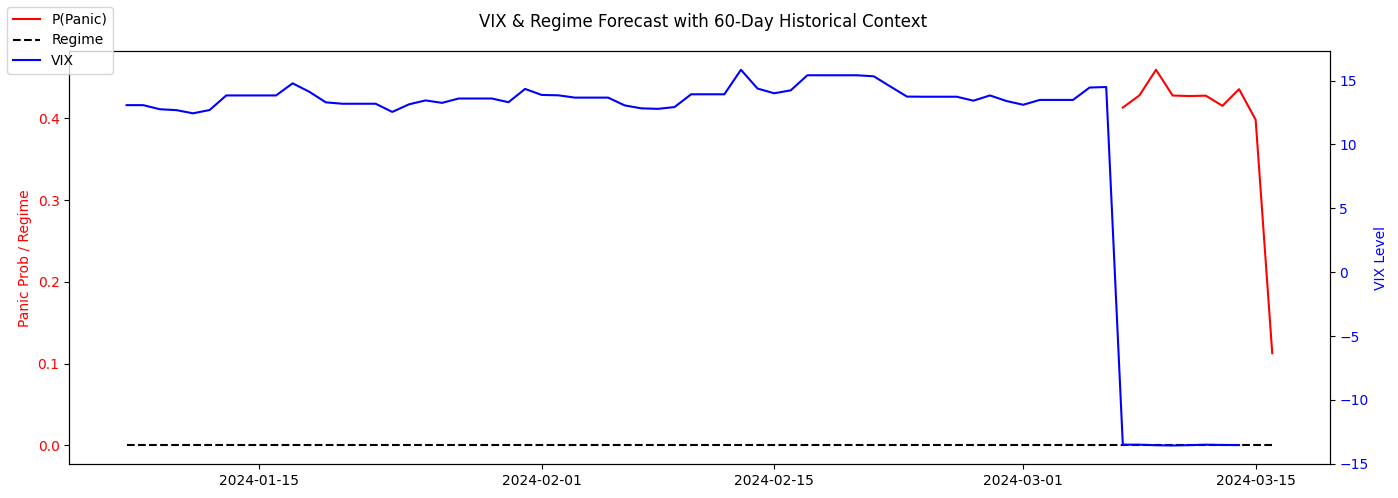

In [284]:
history = df_model[selected_features + ['vix_target', 'regime_t']].copy()
history = history.iloc[-60:].copy()

history = history.rename(columns={
    'vix_target': 'vix_pred',
    'regime_t': 'regime_pred'  # optional
})  # since this wasn't calculated historically

df_full = pd.concat([history, df_forecast], axis=0)


fig, ax1 = plt.subplots(figsize=(14, 5))

# Panic Probability
ax1.plot(df_full.index, df_full['panic_prob'], label='P(Panic)', color='red')
ax1.plot(df_full.index, df_full['regime_pred'], linestyle='--', color='black', label='Regime')
ax1.set_ylabel("Panic Prob / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# VIX Forecast / Actual
ax2 = ax1.twinx()
ax2.plot(df_full.index, df_full['vix_pred'], label='VIX', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.suptitle("VIX & Regime Forecast with 60-Day Historical Context")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()



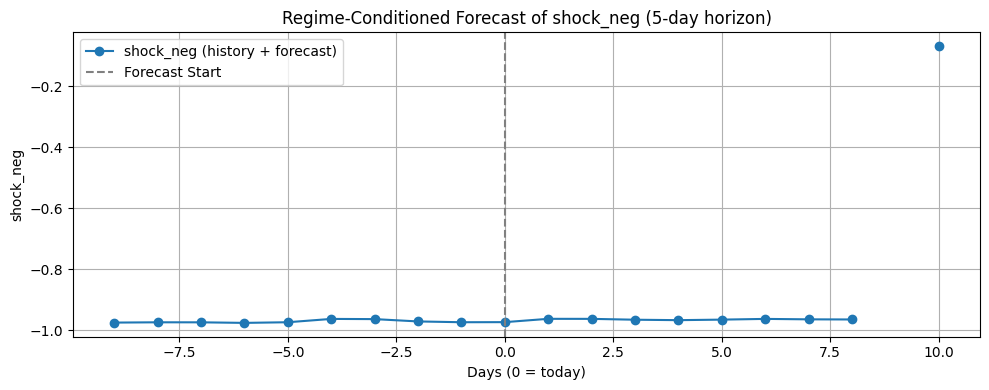

In [285]:
import matplotlib.pyplot as plt

n_history = 10
actual = df_model['shock_neg'].dropna().iloc[-n_history:].tolist()
combined = actual + shock_forecast
x = list(range(-n_history + 1, len(shock_forecast) + 1))

plt.figure(figsize=(10, 4))
plt.plot(x, combined, marker='o', label='shock_neg (history + forecast)')
plt.axvline(0, linestyle='--', color='gray', label='Forecast Start')
plt.title('Regime-Conditioned Forecast of shock_neg (5-day horizon)')
plt.xlabel('Days (0 = today)')
plt.ylabel('shock_neg')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
